# facial-emotion-detection-and-classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import cv2
import os
import pickle
import random

### Let's visualize some image

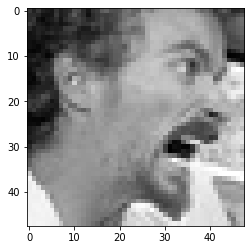

In [4]:
test_img = cv2.imread('/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/angry/PrivateTest_10304478.jpg')
plt.imshow(test_img)
plt.show()

In [5]:
test_img.shape

(48, 48, 3)

In [6]:
def lbp(image):
  def assign_bit(picture, x, y, c):   #comparing bit with threshold value of centre pixel
      bit = 0  
      try:          
          if picture[x][y] >= c: 
              bit = 1         
      except: 
          pass
      return bit 
  def local_bin_val(picture, x, y):  #calculating local binary pattern value of a pixel
      eight_bit_binary = []
      centre = picture[x][y] 
      powers = [1, 2, 4, 8, 16, 32, 64, 128] 
      decimal_val = 0
      #starting from top right,assigning bit to pixels clockwise 
      eight_bit_binary.append(assign_bit(picture, x-1, y + 1,centre)) 
      eight_bit_binary.append(assign_bit(picture, x, y + 1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x + 1, y + 1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x + 1, y, centre)) 
      eight_bit_binary.append(assign_bit(picture, x + 1, y-1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x, y-1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x-1, y-1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x-1, y, centre))     
      #calculating decimal value of the 8-bit binary number
      for i in range(len(eight_bit_binary)): 
          decimal_val += eight_bit_binary[i] * powers[i] 
            
      return decimal_val 
  m, n, _ = image.shape 
  gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #converting image to grayscale
  lbp_image = np.zeros((m, n),np.uint8) 
  # converting image to lbp
  for i in range(0,m): 
      for j in range(0,n): 
          lbp_image[i, j] = local_bin_val(gray_scale, i, j) 
 
  return lbp_image

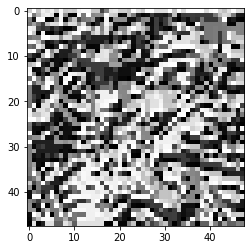

array([[209, 255, 193, ..., 255, 223, 216],
       [252, 121, 176, ..., 126,  30,  24],
       [126,  16, 253, ...,  30,   6,   0],
       ...,
       [ 13, 255, 223, ..., 199, 207, 200],
       [  8, 127, 191, ..., 255,   7,   0],
       [  0, 227,   0, ...,  99, 131, 128]], dtype=uint8)

In [8]:
l=lbp(test_img)
from matplotlib import pyplot as plt
plt.imshow(l, cmap ="gray") 
plt.show()
l

### Taking all the images from the image dataset

In [9]:
path_to_data = '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/'
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [10]:
img_dirs

['/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/sad',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/surprise',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/happy',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/angry',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/disgust',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/neutral',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/fear']

In [11]:
emotions = []
for img_dir in img_dirs:
    emotion_name = img_dir.split('/')[-1]
    emotions.append(emotion_name)

In [12]:
emotions

['sad', 'surprise', 'happy', 'angry', 'disgust', 'neutral', 'fear']

In [14]:
training_data = []
for emotion in emotions:
    path = os.path.join(path_to_data, emotion)
    label = emotions.index(emotion)
    print('{} --> {}'.format(emotion, label))
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        img = cv2.imread(imgpath)
        img = cv2.resize(img, (48, 48))
        lbpImg = lbp(img)
        image = np.array(lbpImg).flatten() 
        training_data.append([image, label])

sad --> 0
surprise --> 1
happy --> 2
angry --> 3
disgust --> 4
neutral --> 5
fear --> 6


In [18]:
print(len(training_data))

3653


### Splitting the data into features and labels where X --> features & y --> labels

In [19]:
random.shuffle(training_data)
X = []
y = []

for feature, label in training_data:
    X.append(feature)
    y.append(label)

### Splitting the data into training and test set

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Fitting the model into train set

In [21]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [23]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.358655,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.230670,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.263514,{'logisticregression__C': 1}


In [24]:
best_estimators

{'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=1, gamma='auto', probability=True))])}

In [25]:
best_estimators['svm'].score(X_test,y_test)

0.36114911080711354

In [26]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.280437756497948

In [27]:
best_estimators['random_forest'].score(X_test,y_test)

0.2558139534883721

In [28]:
best_clf = best_estimators['svm']

In [29]:
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, gamma='auto', probability=True))])

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[56,  9, 18, 15,  4,  2,  6],
       [ 6, 48, 17, 11, 10,  4, 10],
       [16,  5, 53,  9, 11,  3, 14],
       [19, 11, 15, 34,  8,  3, 11],
       [11, 13,  8, 10, 49,  3, 14],
       [12, 13, 19, 17,  4, 11, 16],
       [17, 21, 20, 15, 12,  5, 13]])

Text(69.0, 0.5, 'Truth')

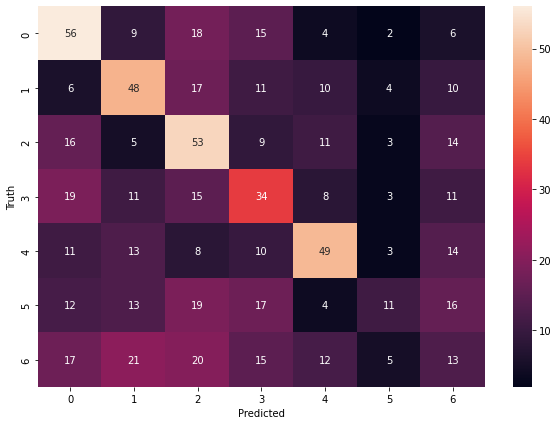

In [31]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')